In [1]:
import pandas as pd

In [2]:
TAHMO_stations = pd.read_csv("../assets/tahmo_stations.csv")

In [75]:
import urllib.request
from tqdm import tqdm as tqdm
from datetime import datetime 
from pcse.util import reference_ET

stations = TAHMO_stations["|"].values
variables = ["te","rh","pr","ap","ra","ws"]
URL = "https://tahmo.org/wp-content/uploads/graphs/"


for station_code in tqdm(stations) :
    # print("station",station_code)

    try:
            
        weather_df_full = pd.DataFrame()

        for variable in tqdm(variables):
            filename = station_code+"_"+variable+"_D.csv"
            urllib.request.urlretrieve(URL+filename, "../data/3_output/TAHMO/"+filename)
            weather_df = pd.read_csv("../data/3_output/TAHMO/"+filename)

            try:
                weather_df_full = weather_df_full.merge(weather_df, left_on="Timestamp", right_on="Timestamp")
            except:
                weather_df_full = weather_df

        # temperature of previous month
        filename = station_code+"_te_H.csv"
        urllib.request.urlretrieve(URL+filename, "../data/3_output/TAHMO/"+filename)
        weather_df = pd.read_csv("../data/3_output/TAHMO/"+filename)
        
        weather_df["day"] = weather_df.apply(lambda x: datetime.strptime(x["Timestamp"],"%Y-%m-%dT%H:%M").date(), axis=1)

        tmin = weather_df[["day","te"]].groupby("day").min().reset_index()
        tmin = tmin.rename(columns={"te":"tmin"})
        tmax = weather_df[["day","te"]].groupby("day").max().reset_index()
        tmax = tmax.rename(columns={"te":"tmax"})

        weather_df_full["day"] = weather_df_full.apply(lambda x: datetime.strptime(x["Timestamp"],"%Y-%m-%d").date(), axis=1)

        weather_df_full = weather_df_full.merge(tmin, left_on="day", right_on="day", how='left')
        weather_df_full = weather_df_full.merge(tmax, left_on="day", right_on="day", how='left')
        
        weather_df_full["lat"] = TAHMO_stations.loc[TAHMO_stations["|"]==station_code, "|__Y"].values[0]
        weather_df_full["ELEV"] = TAHMO_stations.loc[TAHMO_stations["|"]==station_code, "|__Z"].values[0]


        # ra en W/m2
        # on veut du MJ/m2/day
        # 1W/m2 = 86 400 J/m2/day
        weather_df_full["Rg"] = weather_df_full["ra"] * 86400 / 1E6

        # calcul du RH depuis actual vapour pressure : https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
        weather_df_full["es"] = 6.11 * 10 ** ((7.5 * weather_df_full["te"])/(237.3 + weather_df_full["te"]))
        weather_df_full["Vap"] = weather_df_full["rh"]/100 * weather_df_full["es"]

        

        # print("- Computing ET0-PM...")
        ANGSTA = 0.29
        ANGSTB = 0.49
        weather_df_full["ET0_PM"] = weather_df_full.apply(lambda x: reference_ET(x["day"], x["lat"], x["ELEV"], x["tmin"], x["tmax"], x["Rg"]*1E6, x["Vap"], x["ws"], ANGSTA, ANGSTB, ETMODEL="PM")[2], axis=1)
        weather_df_full.loc[pd.isna(weather_df_full["tmin"]),"ET0_PM"] = pd.NA 

        weather_df_full.to_csv("../data/3_output/TAHMO/"+station_code+".csv")
    except:
        pass

100%|██████████| 472/472 [17:59<00:00,  2.29s/it]


In [79]:
big_df = pd.DataFrame()
for station_code in tqdm(stations) :
    try:
        df = pd.read_csv("../data/3_output/TAHMO/"+station_code+".csv")
        df["code_station"] = station_code
        big_df = big_df.append(df)
    except:
        pass

  0%|          | 0/472 [00:00<?, ?it/s]/tmp/ipykernel_2049/2915001671.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(df)
/tmp/ipykernel_2049/2915001671.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(df)
/tmp/ipykernel_2049/2915001671.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(df)
/tmp/ipykernel_2049/2915001671.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(df)
/tmp/ipykernel_2049/2915001671.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

In [80]:
big_df

,Unnamed: 0,Timestamp,te,rh,pr,ap,ra,ws,day,tmin,tmax,lat,ELEV,Rg,es,Vap,ET0_PM,code_station
0,0,2021-12-06,21.690972,0.689753,1.260,86.193507,227.684028,4.483507,2021-12-06,NaN,NaN,-1.123283,1393.0,19.6719,25.952551,0.179009,NaN,TA00001
1,1,2021-12-07,22.235069,0.686066,0.034,86.183542,225.204861,4.593854,2021-12-07,NaN,NaN,-1.123283,1393.0,19.4577,26.827885,0.184057,NaN,TA00001
2,2,2021-12-08,20.532639,0.802603,6.463,86.237187,216.770833,NaN,2021-12-08,NaN,NaN,-1.123283,1393.0,18.7290,24.171727,0.194003,NaN,TA00001
3,3,2021-12-09,20.286458,0.858052,14.423,86.225174,199.177083,NaN,2021-12-09,NaN,NaN,-1.123283,1393.0,17.2089,23.807325,0.204279,NaN,TA00001
4,4,2021-12-10,21.328125,0.777101,0.034,86.089097,181.309028,NaN,2021-12-10,NaN,NaN,-1.123283,1393.0,15.6651,25.382772,0.197250,NaN,TA00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,114,2022-12-02,28.178819,0.663719,0.000,96.910521,279.173611,2.148299,2022-12-02,22.550000,34.458333,-6.465545,363.9,24.1206,38.204680,0.253572,7.346596,TA00780
115,115,2022-12-03,28.262847,0.669517,0.000,96.854062,288.229167,2.497188,2022-12-03,23.933333,34.366667,-6.465545,363.9,24.9030,38.391739,0.257039,8.028643,TA00780
116,116,2022-12-04,28.522569,0.650642,0.000,96.933056,279.340278,2.500417,2022-12-04,24.100000,34.641667,-6.465545,363.9,24.1350,38.974970,0.253588,8.030107,TA00780
117,117,2022-12-05,28.217014,0.619208,0.000,97.025937,274.822917,2.078438,2022-12-05,22.700000,34.975000,-6.465545,363.9,23.7447,38.289608,0.237092,7.240803,TA00780


(array([1.689e+03, 3.355e+03, 5.075e+03, 1.513e+03, 3.820e+02, 8.600e+01,
        2.700e+01, 6.000e+00, 5.000e+00, 1.600e+01]),
 array([ 0.        ,  1.84125312,  3.68250624,  5.52375936,  7.36501248,
         9.2062656 , 11.04751872, 12.88877184, 14.73002495, 16.57127807,
        18.41253119]),
 <BarContainer object of 10 artists>)

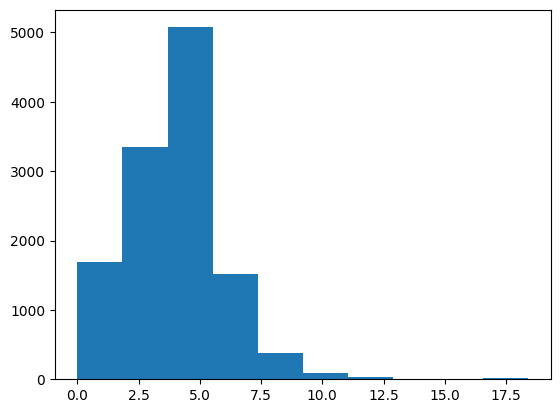

In [81]:
plt.hist(big_df["ET0_PM"])